<a href="https://colab.research.google.com/github/180030814-GnaneshwarReddy/GnaneswaraReddy_INFO5731_Fall2024/blob/main/Palem_Gnaneswara_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from scratch instead of using any pre-existing libraries to do so:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [16]:
# Write your code here
import pandas as pd
from collections import defaultdict
import re

df = pd.read_csv('/content/cleaned_amazon_reviews_1000.csv')

def tokenize(text):
    return text.lower().split()

def count_trigrams(text_data):
    trigram_counts = defaultdict(int)
    for text in text_data:
        tokens = tokenize(text)
        for i in range(len(tokens) - 2):
            trigram = (tokens[i], tokens[i+1], tokens[i+2])
            trigram_counts[trigram] += 1
    return trigram_counts

trigram_counts = count_trigrams(df['Cleaned_Content'])

sorted_trigrams = sorted(trigram_counts.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Trigrams:", sorted_trigrams[:10])

def calculate_bigram_probabilities(text_data):
    bigram_counts = defaultdict(int)
    unigram_counts = defaultdict(int)
    for text in text_data:
        tokens = tokenize(text)
        for i in range(len(tokens) - 1):
            bigram = (tokens[i], tokens[i+1])
            bigram_counts[bigram] += 1
            unigram_counts[tokens[i]] += 1
        if tokens:
            unigram_counts[tokens[-1]] += 1

    bigram_probabilities = {}
    for (w1, w2), bigram_count in bigram_counts.items():
        if unigram_counts[w1] > 0:
            bigram_probabilities[(w1, w2)] = bigram_count / unigram_counts[w1]

    return bigram_probabilities

bigram_probabilities = calculate_bigram_probabilities(df['Cleaned_Content'])

sorted_bigrams = sorted(bigram_probabilities.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Bigrams with Probabilities:", sorted_bigrams[:10])

def extract_noun_phrases(text):
    tokens = tokenize(text)
    noun_phrases = []
    for i in range(len(tokens) - 1):
        if re.match(r'^[a-z]+$', tokens[i]) and re.match(r'^[a-z]+$', tokens[i+1]):
            noun_phrases.append((tokens[i], tokens[i+1]))
    return noun_phrases

noun_phrase_counts = defaultdict(int)
review_noun_phrases = []

for text in df['Cleaned_Content']:
    phrases = extract_noun_phrases(text)
    review_noun_phrases.append(phrases)
    for phrase in phrases:
        noun_phrase_counts[phrase] += 1

max_freq = max(noun_phrase_counts.values()) if noun_phrase_counts else 1

relative_probabilities = []

for phrases in review_noun_phrases:
    review_probs = {}
    for phrase in phrases:
        review_probs[phrase] = noun_phrase_counts[phrase] / max_freq
    relative_probabilities.append(review_probs)
relative_probs_df = pd.DataFrame(relative_probabilities).fillna(0)

print(relative_probs_df.head())



Top 10 Trigrams: [(('lay', 'screen', 'protector'), 182), (('doesnt', 'affect', 'camera'), 182), (('el', 'teléfono', 'llegó'), 165), (('depend', 'del', 'proveedor'), 148), (('llegó', 'en', 'excelent'), 108), (('iphon', 'midnight', 'gb'), 91), (('midnight', 'gb', 'unlock'), 91), (('gb', 'unlock', 'version'), 91), (('unlock', 'version', 'seller'), 91), (('version', 'seller', 'directcertifi'), 91)]
Top 10 Bigrams with Probabilities: [(('base', 'product'), 1.0), (('neat', 'scratch'), 1.0), (('ware', 'tear'), 1.0), (('tear', 'easi'), 1.0), (('easi', 'program'), 1.0), (('detail', 'saw'), 1.0), (('saw', 'batteri'), 1.0), (('mean', 'wasnt'), 1.0), (('wasnt', 'replac'), 1.0), (('fresher', 'one'), 1.0)]
   (review, base)  (base, product)  (product, qualiti)  (qualiti, condit)  \
0        0.203297         0.203297            0.203297           0.203297   
1        0.000000         0.000000            0.000000           0.000000   
2        0.000000         0.000000            0.000000           0.

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any pre-existing libraries to do so.

In [17]:
# Write your code here
import numpy as np
import pandas as pd
from collections import defaultdict
import math


documents = [doc.lower().split() for doc in df['Cleaned_Content']]

def calculate_tf(documents):
    tf = []
    for doc in documents:
        term_count = defaultdict(int)
        for word in doc:
            term_count[word] += 1
        doc_tf = {term: count / len(doc) for term, count in term_count.items()}
        tf.append(doc_tf)
    return tf

def calculate_idf(documents):
    num_docs = len(documents)
    idf = defaultdict(int)
    for doc in documents:
        unique_terms = set(doc)
        for term in unique_terms:
            idf[term] += 1
    idf = {term: math.log(num_docs / (1 + freq)) for term, freq in idf.items()}
    return idf

def calculate_tfidf(tf, idf):
    tfidf = []
    for doc_tf in tf:
        doc_tfidf = {term: tf_val * idf.get(term, 0) for term, tf_val in doc_tf.items()}
        tfidf.append(doc_tfidf)
    return tfidf

tf = calculate_tf(documents)
idf = calculate_idf(documents)
tfidf = calculate_tfidf(tf, idf)

all_terms = set(term for doc in tfidf for term in doc)
tfidf_matrix = pd.DataFrame([{term: doc_tfidf.get(term, 0) for term in all_terms} for doc_tfidf in tfidf])

print("TF-IDF Matrix (first few rows):")
print(tfidf_matrix.head())

sample_query = "An outstanding phone with great performance and excellent battery life"

query_tokens = sample_query.lower().split()
query_tf = defaultdict(int)
for token in query_tokens:
    query_tf[token] += 1
query_tf = {term: count / len(query_tokens) for term, count in query_tf.items()}

query_tfidf = {term: query_tf.get(term, 0) * idf.get(term, 0) for term in all_terms}

def cosine_similarity(vec1, vec2):
    dot_product = sum(vec1[term] * vec2.get(term, 0) for term in vec1)
    magnitude1 = math.sqrt(sum(val ** 2 for val in vec1.values()))
    magnitude2 = math.sqrt(sum(val ** 2 for val in vec2.values()))
    return dot_product / (magnitude1 * magnitude2) if magnitude1 and magnitude2 else 0

similarities = []
for i, doc_tfidf in enumerate(tfidf):
    similarity = cosine_similarity(query_tfidf, doc_tfidf)
    similarities.append((i, similarity))

ranked_documents = sorted(similarities, key=lambda x: x[1], reverse=True)

top_documents = ranked_documents[:5]
print("Top 5 Ranked Documents (index, similarity score):")
print(top_documents)







TF-IDF Matrix (first few rows):
      iphon  although  sell  smartphon      look  satisfecha  hope    camera  \
0  0.000000  0.000000   0.0   0.000000  0.000000         0.0   0.0  0.000000   
1  0.014310  0.000000   0.0   0.000000  0.000000         0.0   0.0  0.009189   
2  0.000000  0.000000   0.0   0.000000  0.046272         0.0   0.0  0.138817   
3  0.000000  0.036155   0.0   0.050787  0.027567         0.0   0.0  0.000000   
4  0.030571  0.000000   0.0   0.000000  0.000000         0.0   0.0  0.039261   

        hey      rear  ...  site  usándolo  sin   exchang  sigu  revis  \
0  0.000000  0.000000  ...   0.0       0.0  0.0  0.000000   0.0    0.0   
1  0.000000  0.016929  ...   0.0       0.0  0.0  0.016929   0.0    0.0   
2  0.000000  0.000000  ...   0.0       0.0  0.0  0.000000   0.0    0.0   
3  0.036155  0.000000  ...   0.0       0.0  0.0  0.000000   0.0    0.0   
4  0.000000  0.000000  ...   0.0       0.0  0.0  0.000000   0.0    0.0   

   differ  againrefurbishedrenewedtomaytoe

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

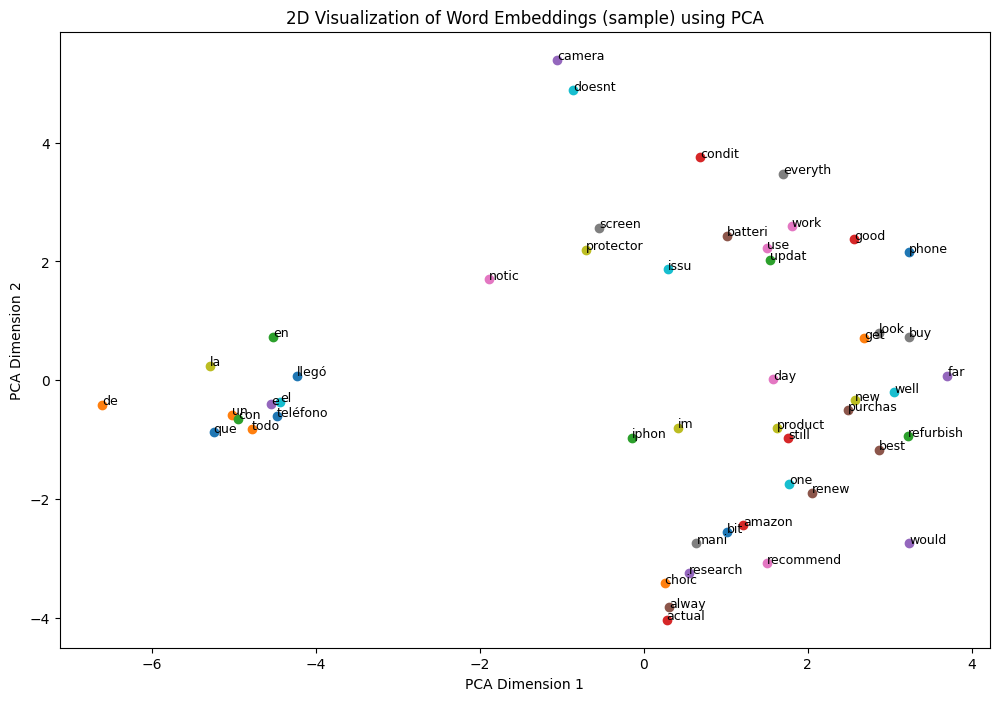

In [18]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

embedding_dim = 300
word2vec_model = Word2Vec(sentences=documents, vector_size=embedding_dim, window=5, min_count=2, workers=4)

word2vec_model.save("word2vec_embedding.model")

sample_words = list(word2vec_model.wv.index_to_key)[:50]  # Limit to the first 50 words for clarity
sample_vectors = [word2vec_model.wv[word] for word in sample_words]

import numpy as np
sample_vectors_np = np.array(sample_vectors)

pca = PCA(n_components=2)
reduced_vectors_pca = pca.fit_transform(sample_vectors_np)

plt.figure(figsize=(12, 8))
for i, word in enumerate(sample_words):
    plt.scatter(reduced_vectors_pca[i, 0], reduced_vectors_pca[i, 1])
    plt.annotate(word, (reduced_vectors_pca[i, 0], reduced_vectors_pca[i, 1]), fontsize=9)
plt.title("2D Visualization of Word Embeddings (sample) using PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()


## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.


In [ ]:
# The GitHub link of your final csv file


# Link:https://github.com/180030814-GnaneshwarReddy/GnaneswaraReddy_INFO5731_Fall2024/blob/main/amazon_reviews_sentiment_analysis.csv



# Mandatory Question

Provide your thoughts on the assignment. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# Type your answer
# I found it challenging when I was programming for question 1 where we have to count the frequencies of the n-grams and calculate the probability of the bigrams.
# And I enjoyed when I was working on the question 3 where you have to create a new model which gave me a new experience.